In [1]:
# Torch imports
import torch
from torchvision.transforms import v2

# File reading
import os
import pickle
from glob import glob

# Utils
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt

# 1. Global Annotations File 

In [19]:
# Annotations structure
file = './datasets/with-augmentations/Room1/Setting1/episode_0001/episode_0001.pkl'
with open(file, 'rb') as f:
    df = pickle.load(f)
    display(df.head())

,episode,step,target_point_x,target_point_y,robot_pos_x,robot_pos_y,robot_yaw,robot_1_rel_pos_x,robot_1_rel_pos_y,robot_1_in_fov,robot_2_rel_pos_x,robot_2_rel_pos_y,robot_2_in_fov,robot_3_rel_pos_x,robot_3_rel_pos_y,robot_3_in_fov,laser_readings,robot_1_body_id,robot_2_body_id,robot_3_body_id
1,1,1,2.5,0.0,-2.505200,-0.000251,0.088535,4.826114,-1.423542,True,-1.763203,-2.445634,False,2.338339,-2.953828,True,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
2,1,2,2.5,0.0,-2.522301,-0.003537,0.272435,4.502128,-2.282922,True,-2.161676,-2.078131,False,1.775713,-3.335012,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
3,1,3,2.5,0.0,-2.539912,-0.009385,0.566763,3.659233,-3.499867,True,-2.648863,-1.360433,False,0.748445,-3.714144,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
4,1,4,2.5,0.0,-2.535265,-0.002515,0.902228,2.288725,-4.512129,False,-2.950893,-0.409430,False,-0.526199,-3.756534,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
5,1,5,2.5,0.0,-2.522608,0.018057,1.140661,1.127238,-4.921282,False,-2.980833,0.303563,False,-1.424795,-3.525146,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0


In [ ]:
# Filter warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Create a global annotations file
ep_dfs = []
for room in range(1, len(glob('./datasets/with-augmentations/*'))+1):
    room_dir = f'./datasets/with-augmentations/Room{room}'

    for setting in range(1, len(glob(f'{room_dir}/*'))+1):
        set_dir = f'{room_dir}/Setting{setting}'
        for ep_dir in sorted(glob(f'{set_dir}/episode_*')):     

            ep = ep_dir.split('/')[-1]
            try:
                with open(f'{ep_dir}/{ep}.pkl', 'rb') as f:
                    df = pickle.load(f)
                    df.insert(0, 'setting', np.ones(df.shape[0], dtype=int) * setting)
                    df.insert(0, 'room', np.ones(df.shape[0], dtype=int) * room)
                    ep_dfs.append(df)
            except FileNotFoundError:
                print(f'File not found: {ep_dir}/{ep}.pkl')

ep_dfs = pd.concat(ep_dfs)
ep_dfs.index = list(range(0, ep_dfs.shape[0]))

display(ep_dfs.head())

File not found: ./datasets/with-augmentations/Room1/Setting3/episode_0010/episode_0010.pkl
File not found: ./datasets/with-augmentations/Room1/Setting4/episode_0010/episode_0010.pkl
File not found: ./datasets/with-augmentations/Room1/Setting5/episode_0010/episode_0010.pkl
File not found: ./datasets/with-augmentations/Room1/Setting6/episode_0010/episode_0010.pkl
File not found: ./datasets/with-augmentations/Room1/Setting7/episode_0010/episode_0010.pkl
File not found: ./datasets/with-augmentations/Room1/Setting8/episode_0010/episode_0010.pkl
File not found: ./datasets/with-augmentations/Room1/Setting9/episode_0010/episode_0010.pkl
File not found: ./datasets/with-augmentations/Room1/Setting10/episode_0010/episode_0010.pkl
File not found: ./datasets/with-augmentations/Room2/Setting1/episode_0010/episode_0010.pkl
File not found: ./datasets/with-augmentations/Room2/Setting2/episode_0010/episode_0010.pkl
File not found: ./datasets/with-augmentations/Room2/Setting3/episode_0010/episode_0010.pk

,setting,room,episode,step,target_point_x,target_point_y,robot_pos_x,robot_pos_y,robot_yaw,robot_1_rel_pos_x,...,robot_2_rel_pos_x,robot_2_rel_pos_y,robot_2_in_fov,robot_3_rel_pos_x,robot_3_rel_pos_y,robot_3_in_fov,laser_readings,robot_1_body_id,robot_2_body_id,robot_3_body_id
0,1,1,1,1,2.5,0.0,-2.505200,-0.000251,0.088535,4.826114,...,-1.763203,-2.445634,False,2.338339,-2.953828,True,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
1,1,1,1,2,2.5,0.0,-2.522301,-0.003537,0.272435,4.502128,...,-2.161676,-2.078131,False,1.775713,-3.335012,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
2,1,1,1,3,2.5,0.0,-2.539912,-0.009385,0.566763,3.659233,...,-2.648863,-1.360433,False,0.748445,-3.714144,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
3,1,1,1,4,2.5,0.0,-2.535265,-0.002515,0.902228,2.288725,...,-2.950893,-0.409430,False,-0.526199,-3.756534,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
4,1,1,1,5,2.5,0.0,-2.522608,0.018057,1.140661,1.127238,...,-2.980833,0.303563,False,-1.424795,-3.525146,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0


In [21]:
# Save the annotations file (will be used in the torch Dataset object)
if not os.path.exists('./datasets/with-augmentations/annotations.pkl'):
    ep_dfs.to_pickle('./datasets/with-augmentations/annotations.pkl')

# 2. Image Analysis

In [145]:
file = './datasets/with-augmentations/annotations.pkl'
with open(file, 'rb') as f:
    ep_dfs = pickle.load(f)
    display(ep_dfs.head())

print(f"Number of records: {ep_dfs.shape[0]}")

,room,setting,episode,step,target_point_x,target_point_y,robot_pos_x,robot_pos_y,robot_yaw,robot_1_rel_pos_x,...,robot_2_rel_pos_x,robot_2_rel_pos_y,robot_2_in_fov,robot_3_rel_pos_x,robot_3_rel_pos_y,robot_3_in_fov,laser_readings,robot_1_body_id,robot_2_body_id,robot_3_body_id
0,1,1,1,1,2.5,0.0,-2.505200,-0.000251,0.088535,4.826114,...,-1.763203,-2.445634,False,2.338339,-2.953828,True,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
1,1,1,1,2,2.5,0.0,-2.522301,-0.003537,0.272435,4.502128,...,-2.161676,-2.078131,False,1.775713,-3.335012,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
2,1,1,1,3,2.5,0.0,-2.539912,-0.009385,0.566763,3.659233,...,-2.648863,-1.360433,False,0.748445,-3.714144,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
3,1,1,1,4,2.5,0.0,-2.535265,-0.002515,0.902228,2.288725,...,-2.950893,-0.409430,False,-0.526199,-3.756534,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
4,1,1,1,5,2.5,0.0,-2.522608,0.018057,1.140661,1.127238,...,-2.980833,0.303563,False,-1.424795,-3.525146,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0


Number of records: 19437


In [146]:
# Random sample as anchor
rand_idx = np.random.randint(1, ep_dfs.shape[0] + 1)

anchor_rec = ep_dfs.iloc[rand_idx]
room = anchor_rec['room']
setting = anchor_rec['setting']
ep = anchor_rec['episode']
step = anchor_rec['step']

f"{room}", f"{setting}", f"{ep:04}", f"{step:05}"

('2', '7', '0003', '00110')

In [147]:
anchor_rec

room                                                                 2
setting                                                              7
episode                                                              3
step                                                               110
target_point_x                                                     2.5
target_point_y                                                     0.0
robot_pos_x                                                   0.911698
robot_pos_y                                                   0.274191
robot_yaw                                                    -0.438441
robot_1_rel_pos_x                                            -3.435432
robot_1_rel_pos_y                                            -2.813866
robot_1_in_fov                                                   False
robot_2_rel_pos_x                                             0.201214
robot_2_rel_pos_y                                             1.213191
robot_

In [148]:
# Look for positive examples in either other rooms or settings
pos_df = ep_dfs[(ep_dfs['room'] != anchor_rec['room']) | (ep_dfs['setting'] != anchor_rec['setting'])].copy()
pos_df

,room,setting,episode,step,target_point_x,target_point_y,robot_pos_x,robot_pos_y,robot_yaw,robot_1_rel_pos_x,...,robot_2_rel_pos_x,robot_2_rel_pos_y,robot_2_in_fov,robot_3_rel_pos_x,robot_3_rel_pos_y,robot_3_in_fov,laser_readings,robot_1_body_id,robot_2_body_id,robot_3_body_id
0,1,1,1,1,2.5,0.0,-2.505200,-0.000251,0.088535,4.826114,...,-1.763203,-2.445634,False,2.338339,-2.953828,True,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
1,1,1,1,2,2.5,0.0,-2.522301,-0.003537,0.272435,4.502128,...,-2.161676,-2.078131,False,1.775713,-3.335012,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
2,1,1,1,3,2.5,0.0,-2.539912,-0.009385,0.566763,3.659233,...,-2.648863,-1.360433,False,0.748445,-3.714144,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
3,1,1,1,4,2.5,0.0,-2.535265,-0.002515,0.902228,2.288725,...,-2.950893,-0.409430,False,-0.526199,-3.756534,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
4,1,1,1,5,2.5,0.0,-2.522608,0.018057,1.140661,1.127238,...,-2.980833,0.303563,False,-1.424795,-3.525146,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19432,2,10,9,95,2.5,0.0,2.148549,0.440679,-0.448685,3.561599,...,-6.517727,-4.626626,False,1.312819,0.686854,True,"{'scan': [[0.11502454], [0.11180131], [0.10878...",9.0,10.0,11.0
19433,2,10,9,96,2.5,0.0,2.192943,0.418303,-0.487883,3.624322,...,-6.398505,-4.910989,False,1.228000,0.742738,True,"{'scan': [[0.113904215], [0.1104313], [0.10718...",9.0,10.0,11.0
19434,2,10,9,97,2.5,0.0,2.236652,0.394129,-0.525299,3.678385,...,-6.273469,-5.180602,False,1.143597,0.796684,True,"{'scan': [[0.11222798], [0.108507], [0.1050449...",9.0,10.0,11.0
19435,2,10,9,98,2.5,0.0,2.279233,0.368403,-0.563286,3.731676,...,-6.131744,-5.450736,False,1.060822,0.846992,True,"{'scan': [[0.109117076], [0.10516085], [0.1014...",9.0,10.0,11.0


In [149]:
# Look for negative examples in other episodes of the same setting of the room
neg_df = ep_dfs[(ep_dfs['room'] == anchor_rec['room']) & (ep_dfs['setting'] == anchor_rec['setting']) & (ep_dfs['episode'] != anchor_rec['episode'])].copy()
neg_df

,room,setting,episode,step,target_point_x,target_point_y,robot_pos_x,robot_pos_y,robot_yaw,robot_1_rel_pos_x,...,robot_2_rel_pos_x,robot_2_rel_pos_y,robot_2_in_fov,robot_3_rel_pos_x,robot_3_rel_pos_y,robot_3_in_fov,laser_readings,robot_1_body_id,robot_2_body_id,robot_3_body_id
15742,2,7,1,1,2.5,0.0,-2.495412,0.000312,0.092876,5.667392,...,2.388803,0.964102,True,-2.011731,1.606002,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
15743,2,7,1,2,2.5,0.0,-2.478950,0.003634,0.297152,5.666039,...,2.524261,0.449366,True,-1.659000,1.983702,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
15744,2,7,1,3,2.5,0.0,-2.458075,0.012812,0.545280,5.340050,...,2.543523,-0.204368,True,-1.142605,2.334622,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
15745,2,7,1,4,2.5,0.0,-2.438013,0.028337,0.772055,4.744316,...,2.414214,-0.791845,True,-0.613590,2.534774,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
15746,2,7,1,5,2.5,0.0,-2.422965,0.046516,1.013511,3.851592,...,2.136544,-1.367172,True,-0.012952,2.611221,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16901,2,7,9,101,2.5,0.0,1.907963,0.080586,-0.357856,2.292349,...,-4.180133,-6.719972,False,-5.203794,-3.737038,False,"{'scan': [[0.20807445], [0.20336963], [0.19893...",9.0,10.0,11.0
16902,2,7,9,102,2.5,0.0,1.956326,0.062988,-0.338363,2.142358,...,-4.367094,-6.630574,False,-5.309917,-3.645244,False,"{'scan': [[0.19875711], [0.19442585], [0.19033...",9.0,10.0,11.0
16903,2,7,9,103,2.5,0.0,2.004987,0.046402,-0.318275,1.992008,...,-4.557363,-6.537100,False,-5.416346,-3.553329,False,"{'scan': [[0.19011956], [0.1861311], [0.182362...",9.0,10.0,11.0
16904,2,7,9,104,2.5,0.0,2.053943,0.030749,-0.298692,1.846966,...,-4.743538,-6.444751,False,-5.524384,-3.466653,False,"{'scan': [[0.18234755], [0.17866145], [0.17517...",9.0,10.0,11.0


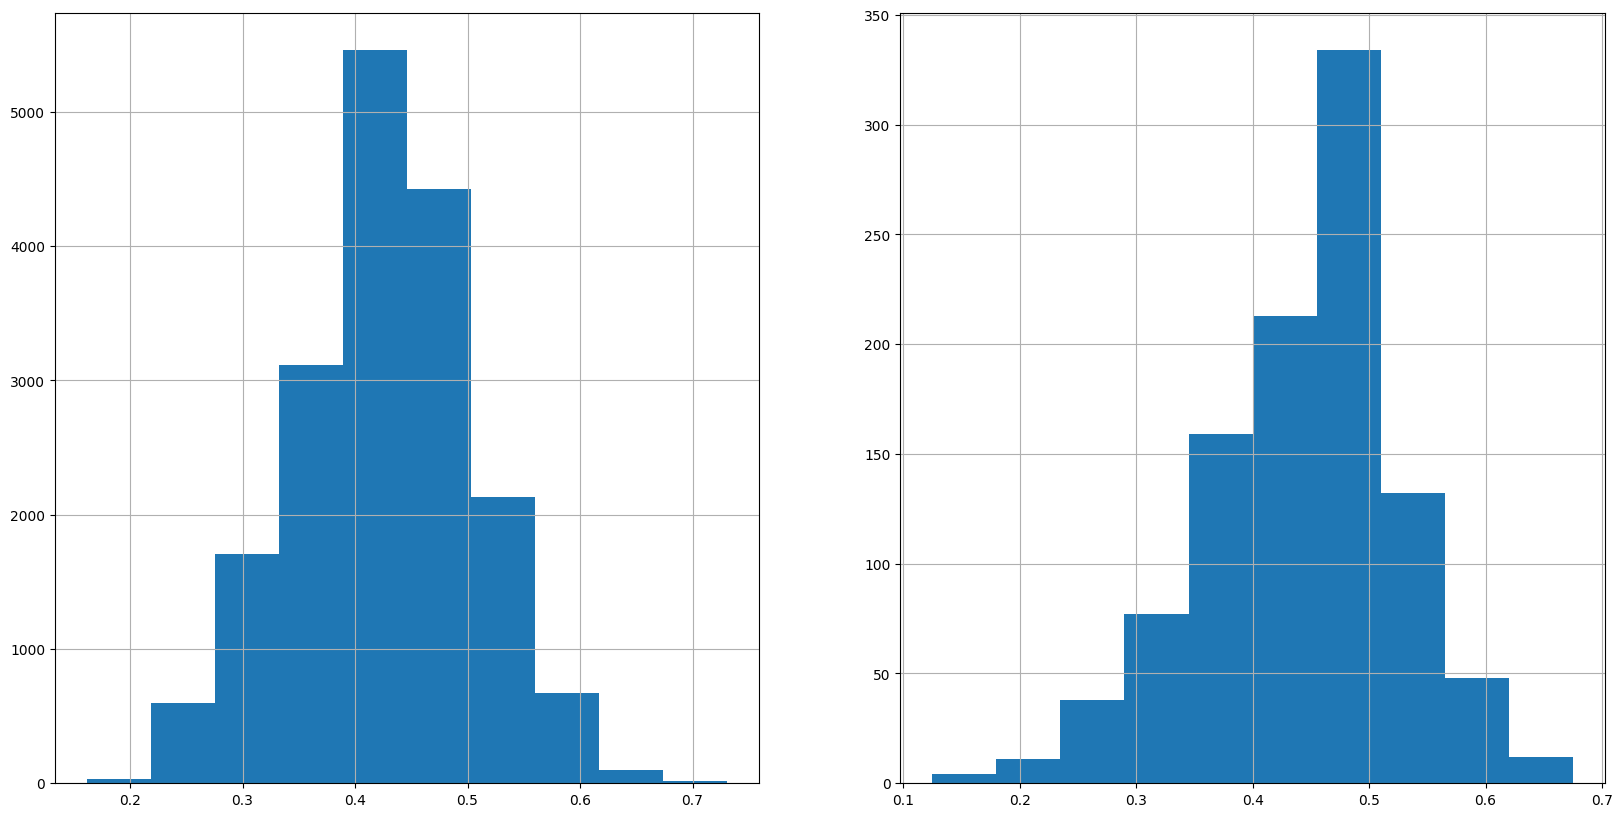

In [150]:
# Weight vector
anc_scan = anchor_rec.laser_readings['scan'].squeeze()
w = np.zeros(anc_scan.shape[0])
# In FOV readings (consider only them for binary masking)
w[64:164] += 1 
# Out of FOV readings (consider also them for soft masking)
x = np.linspace(0.0, 1.0, w[164:].shape[0])
sigmoid = 1 - 0.9*(1 / (1+np.exp(-x))) # Sigmoid 1.0 -> 0.1
w[164:] += sigmoid
w[63::-1] += sigmoid

# Normalizer
den = np.sqrt(w.sum())

# Normalized weighted Eucledian distances on LiDAR readings 
pos_l2_dist = pos_df['laser_readings'].map(lambda x: np.sqrt(np.sum(w*(anc_scan - x['scan'].squeeze())**2)) / den)
neg_l2_dist = neg_df['laser_readings'].map(lambda x: np.sqrt(np.sum(w*(anc_scan - x['scan'].squeeze())**2)) / den)

fig = plt.figure(figsize=[20,10])
ax = fig.add_subplot(1,2,1)
pos_l2_dist.hist(ax=ax);
bx = fig.add_subplot(1,2,2)
neg_l2_dist.hist(ax=bx);

In [151]:
np.where(w == 1)[0].shape

(100,)

-5 -5


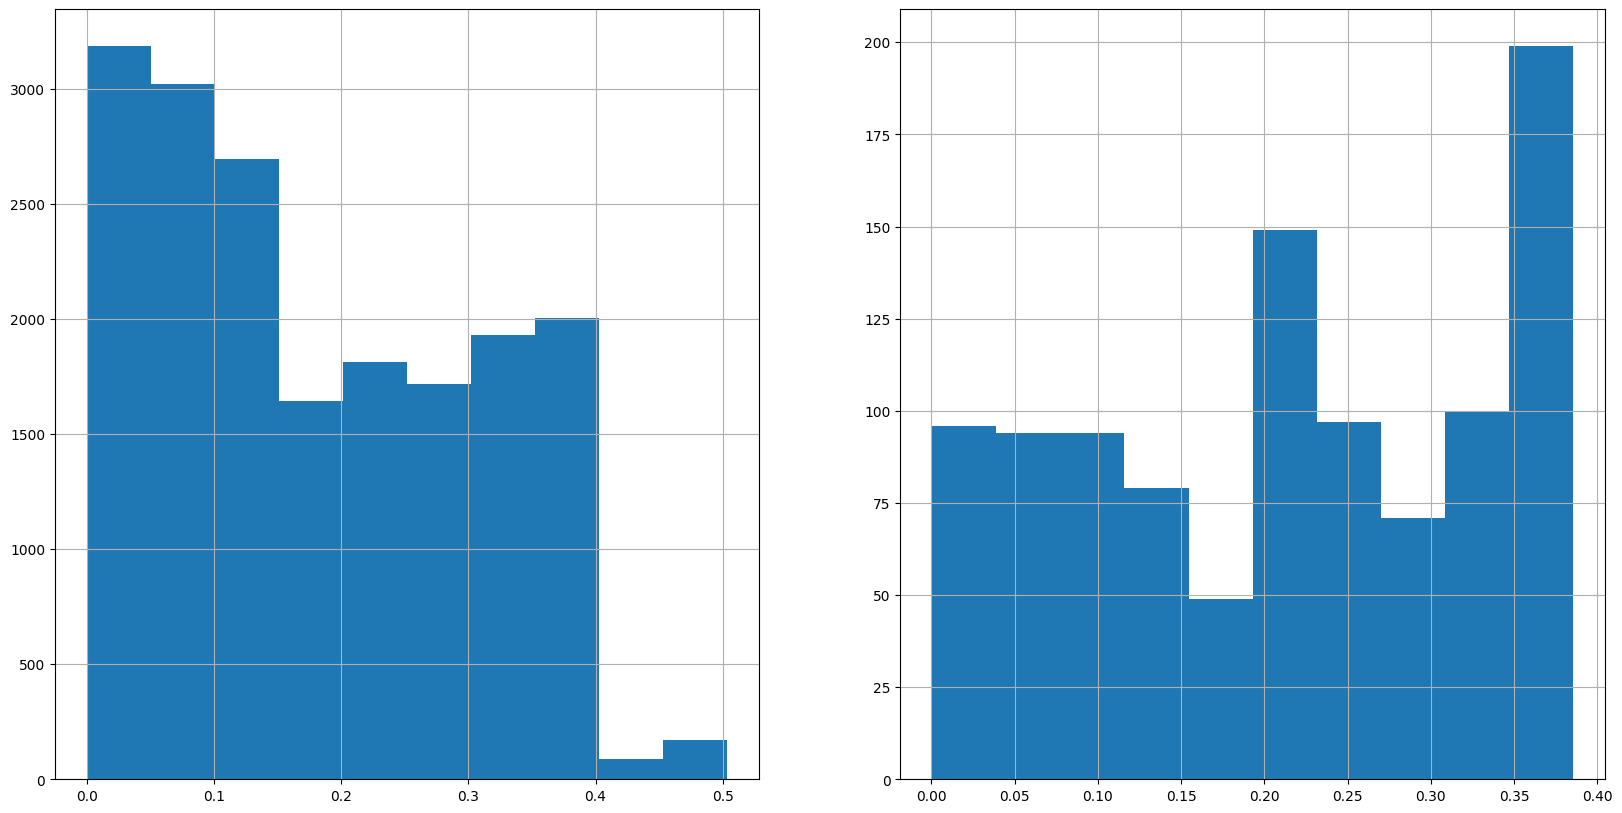

In [152]:
def opposite_corner(x, y):
    opposite_x = -5 if x >= 0 else 5
    opposite_y = -5 if y >= 0 else 5
    return opposite_x, opposite_y

# Normalized goal distance difference 
goal_pos_x, goal_pos_y = anchor_rec['target_point_x'], anchor_rec['target_point_y']
corner_x, corner_y = opposite_corner(goal_pos_x, goal_pos_y)
print(corner_x, corner_y)
max_gd = np.sqrt((goal_pos_x - corner_x)**2 + (goal_pos_y - corner_y)**2)

anchor_gd = np.sqrt((anchor_rec['robot_pos_x'] - goal_pos_x)**2 + (anchor_rec['robot_pos_y'] - goal_pos_y)**2)
pos_gd_diffs = pos_df.apply(lambda x: abs(anchor_gd - np.sqrt((x['robot_pos_x'] - goal_pos_x)**2 + (x['robot_pos_y'] - goal_pos_y)**2)), axis=1) / max_gd 
neg_gd_diffs = neg_df.apply(lambda x: abs(anchor_gd - np.sqrt((x['robot_pos_x'] - goal_pos_x)**2 + (x['robot_pos_y'] - goal_pos_y)**2)), axis=1) / max_gd

fig = plt.figure(figsize=[20,10])
ax = fig.add_subplot(1,2,1)
pos_gd_diffs.hist(ax=ax);
bx = fig.add_subplot(1,2,2)
neg_gd_diffs.hist(ax=bx);

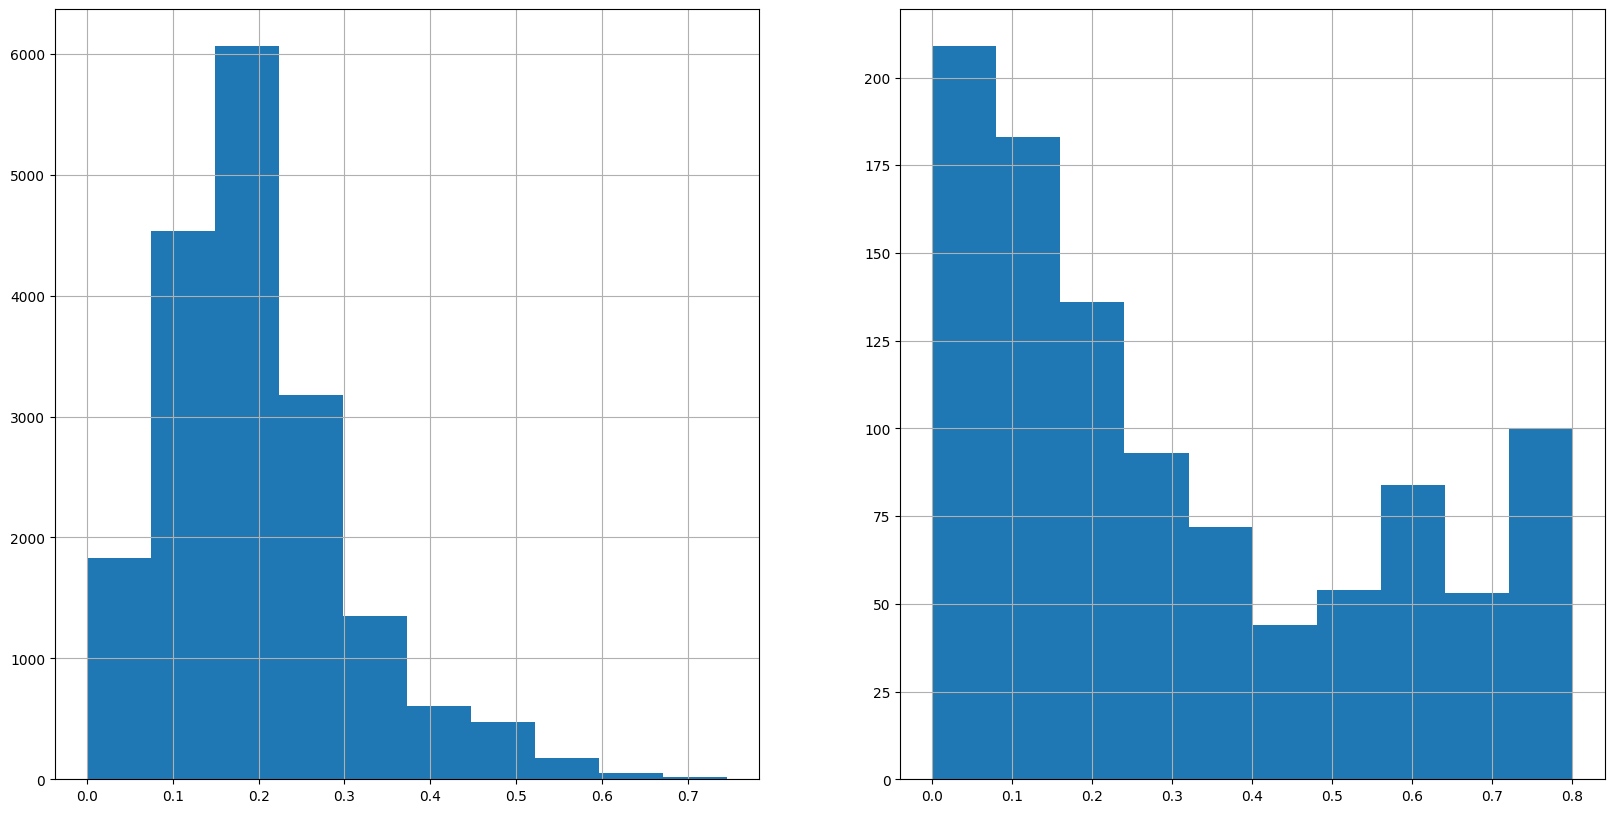

In [ ]:
# Normalize angle between [-pi, pi]
def normalize_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

# Compute angle with respect to the goal considering robot's orientation
def relative_angle(record):
    # Info
    robot_x, robot_y = record['robot_pos_x'], record['robot_pos_y']
    goal_x, goal_y = record['target_point_x'], record['target_point_y']
    theta_r = record['robot_yaw'] 

    # Relative angle
    dx = goal_x - robot_x
    dy = goal_y - robot_y
    theta_g = np.arctan2(dy, dx)
    return normalize_angle(theta_g - theta_r)

# Orientation towards goal position
anchor_phi = relative_angle(anchor_rec)
pos_ori_diff = pos_df.apply(lambda x: np.abs(normalize_angle(anchor_phi - relative_angle(x))) / np.pi, axis=1) 
neg_ori_diff = neg_df.apply(lambda x: np.abs(normalize_angle(anchor_phi - relative_angle(x))) / np.pi, axis=1)

fig = plt.figure(figsize=[20,10])
ax = fig.add_subplot(1,2,1)
pos_ori_diff.hist(ax=ax);
bx = fig.add_subplot(1,2,2)
neg_ori_diff.hist(ax=bx);

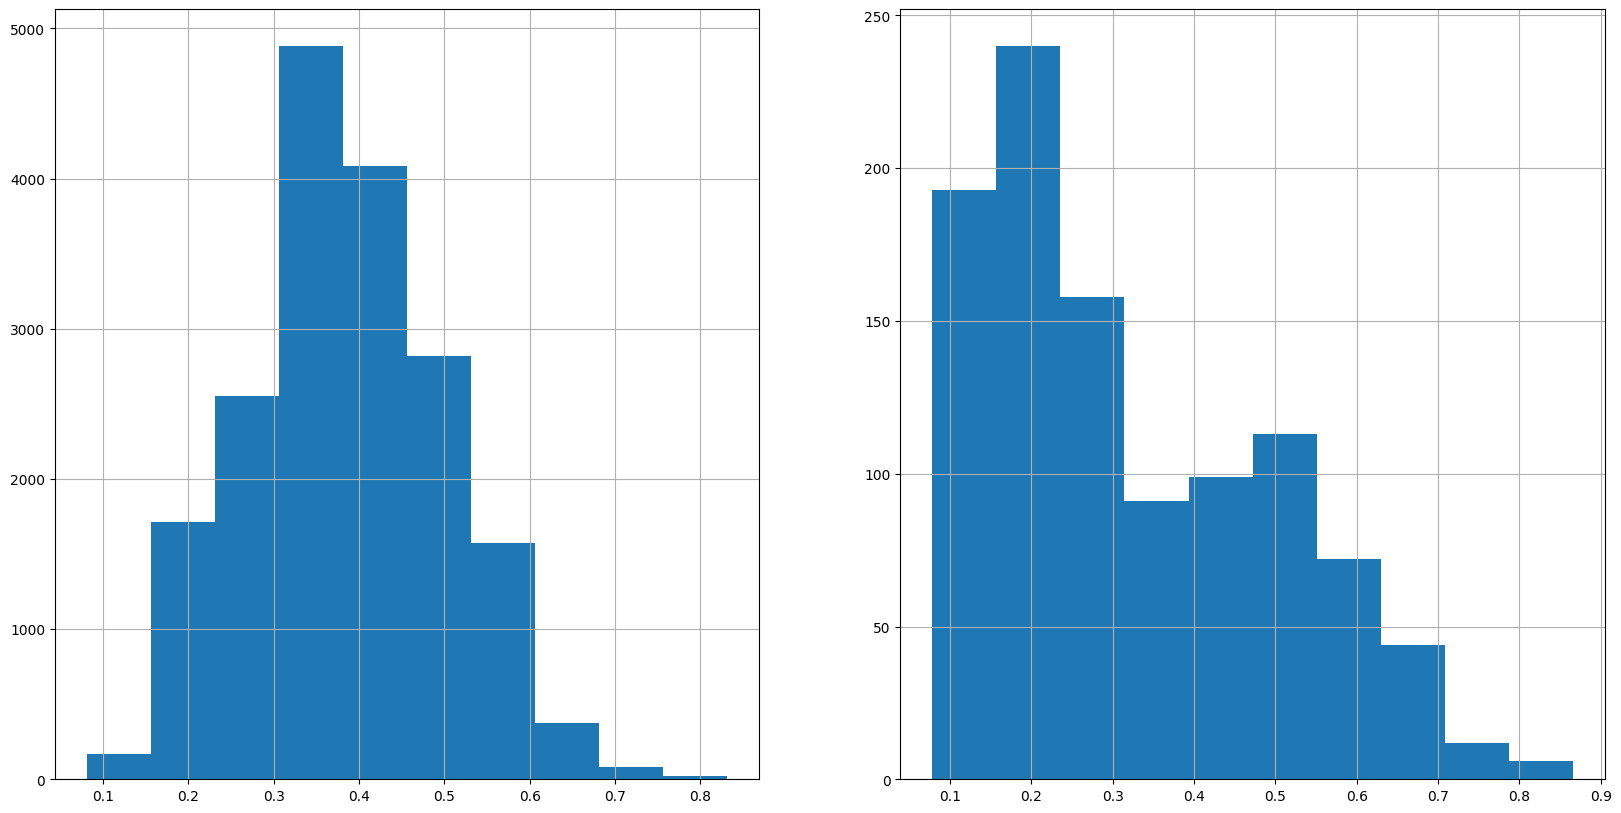

In [154]:
# Combine distances for computing similarities
pos_sim_scores = (1 - pos_l2_dist)*(1 - pos_gd_diffs)*(1 - pos_ori_diff)
neg_sim_scores = (1 - neg_l2_dist)*(1 - neg_gd_diffs)*(1 - neg_ori_diff)

fig = plt.figure(figsize=[20,10])
ax = fig.add_subplot(1,2,1)
pos_sim_scores.hist(ax=ax);
bx = fig.add_subplot(1,2,2)
neg_sim_scores.hist(ax=bx);

In [155]:
# Negative examples mining
BASE_NEG_DIST = 0.4
N_NEG_SAMPLES = 12

negative = neg_sim_scores[neg_sim_scores < BASE_NEG_DIST]
while negative.shape[0] < N_NEG_SAMPLES*2:
    BASE_NEG_DIST += 0.05
    negative = neg_sim_scores[neg_sim_scores < BASE_NEG_DIST]

neg_ex = negative.sample(n=N_NEG_SAMPLES)
neg_ex

15791    0.188779
15797    0.182887
16722    0.230107
16617    0.271381
16455    0.081865
15931    0.329717
15996    0.389143
16354    0.086139
16404    0.094659
16270    0.155241
16540    0.316716
15887    0.237838
dtype: float64

In [156]:
negative_rec = ep_dfs.iloc[neg_ex.index]
negative_rec

,room,setting,episode,step,target_point_x,target_point_y,robot_pos_x,robot_pos_y,robot_yaw,robot_1_rel_pos_x,...,robot_2_rel_pos_x,robot_2_rel_pos_y,robot_2_in_fov,robot_3_rel_pos_x,robot_3_rel_pos_y,robot_3_in_fov,laser_readings,robot_1_body_id,robot_2_body_id,robot_3_body_id
15791,2,7,1,50,2.5,0.0,-1.819287,1.367437,0.804976,3.435703,...,0.422264,-1.501726,False,-2.832010,2.704511,False,"{'scan': [[0.19246654], [0.19351165], [0.19463...",9.0,10.0,11.0
15797,2,7,1,56,2.5,0.0,-1.670204,1.501298,0.688078,3.567362,...,0.478364,-1.489856,False,-3.247713,2.344861,False,"{'scan': [[0.21005367], [0.21069136], [0.21140...",9.0,10.0,11.0
16722,2,7,8,25,2.5,0.0,-1.696450,0.701867,0.460084,-3.880283,...,-2.286888,-3.561451,False,-4.542682,-3.131857,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
16617,2,7,7,22,2.5,0.0,-1.815001,0.602003,0.421147,-0.878723,...,6.333049,-1.019762,True,1.666869,-1.811522,True,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
16455,2,7,5,221,2.5,0.0,1.209031,-3.322489,-2.846498,2.846878,...,3.433414,-6.433521,False,1.199580,-3.495822,False,"{'scan': [[0.36416167], [0.36263394], [0.36124...",9.0,10.0,11.0
15931,2,7,2,48,2.5,0.0,-0.997083,1.021518,-0.314899,4.660611,...,3.652754,0.848204,True,-2.867621,3.401443,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
15996,2,7,2,113,2.5,0.0,2.108924,-0.204495,-0.163708,0.232176,...,-0.147636,1.045867,False,-5.594342,4.372831,False,"{'scan': [[0.10743637], [0.10571979], [0.10409...",9.0,10.0,11.0
16354,2,7,5,120,2.5,0.0,0.331613,-3.203313,-3.121137,3.620686,...,4.510167,-5.853087,True,2.265303,-3.318799,False,"{'scan': [[0.37538987], [0.37163785], [0.36808...",9.0,10.0,11.0
16404,2,7,5,170,2.5,0.0,0.936509,-3.280903,-3.031904,3.801097,...,4.246270,-6.031058,False,1.861774,-2.999765,False,"{'scan': [[0.375641], [0.37265706], [0.3698459...",9.0,10.0,11.0
16270,2,7,5,36,2.5,0.0,-2.476715,-0.914520,1.749878,4.503863,...,4.010185,0.557236,True,1.286476,-0.064555,True,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0


In [157]:
# Retrieve negative records
neg_imgs = []
for _, neg_rec in negative_rec.iterrows():
    neg_room = neg_rec['room']
    neg_set = neg_rec['setting']
    neg_ep = neg_rec['episode']
    neg_step = neg_rec['step']
    neg_imgs.append((f'./datasets/with-augmentations/Room{neg_room}/Setting{neg_set}/episode_{neg_ep:04}/rgb_{neg_step:05}.png', neg_room, neg_set, neg_ep, neg_step))

In [158]:
# Positive examples mining
BASE_POS_DIST = 0.9
N_POS_SAMPLES = 4

positive = pos_sim_scores[pos_sim_scores > BASE_POS_DIST]
while positive.shape[0] < N_POS_SAMPLES*2:
    BASE_POS_DIST -= 0.001
    positive = pos_sim_scores[pos_sim_scores > BASE_POS_DIST]

pos_ex = positive.sample(n=N_POS_SAMPLES)
pos_ex

13732    0.815816
13733    0.786489
13728    0.792695
13417    0.776991
dtype: float64

In [159]:
positive_rec = ep_dfs.iloc[pos_ex.index]
positive_rec

,room,setting,episode,step,target_point_x,target_point_y,robot_pos_x,robot_pos_y,robot_yaw,robot_1_rel_pos_x,...,robot_2_rel_pos_x,robot_2_rel_pos_y,robot_2_in_fov,robot_3_rel_pos_x,robot_3_rel_pos_y,robot_3_in_fov,laser_readings,robot_1_body_id,robot_2_body_id,robot_3_body_id
13732,2,4,9,84,2.5,0.0,0.994276,0.323027,-0.459086,-0.132317,...,-3.956681,1.835791,False,1.020420,2.570379,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
13733,2,4,9,85,2.5,0.0,1.040993,0.300265,-0.446211,-0.253980,...,-3.989183,1.925343,False,1.008391,2.570428,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
13728,2,4,9,80,2.5,0.0,0.808709,0.417797,-0.478119,0.158889,...,-3.749792,1.671440,False,1.143350,2.571012,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
13417,2,4,6,92,2.5,0.0,0.996493,0.572372,-0.604286,-5.499316,...,-0.207845,-1.233238,False,2.840630,0.772441,True,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0


In [160]:
# Retrieve positive records
pos_imgs = []
for _, pos_rec in positive_rec.iterrows():
    pos_room = pos_rec['room']
    pos_set = pos_rec['setting']
    pos_ep = pos_rec['episode']
    pos_step = pos_rec['step']
    pos_imgs.append((f'./datasets/with-augmentations/Room{pos_room}/Setting{pos_set}/episode_{pos_ep:04}/rgb_{pos_step:05}.png', pos_room, pos_set, pos_ep, pos_step))

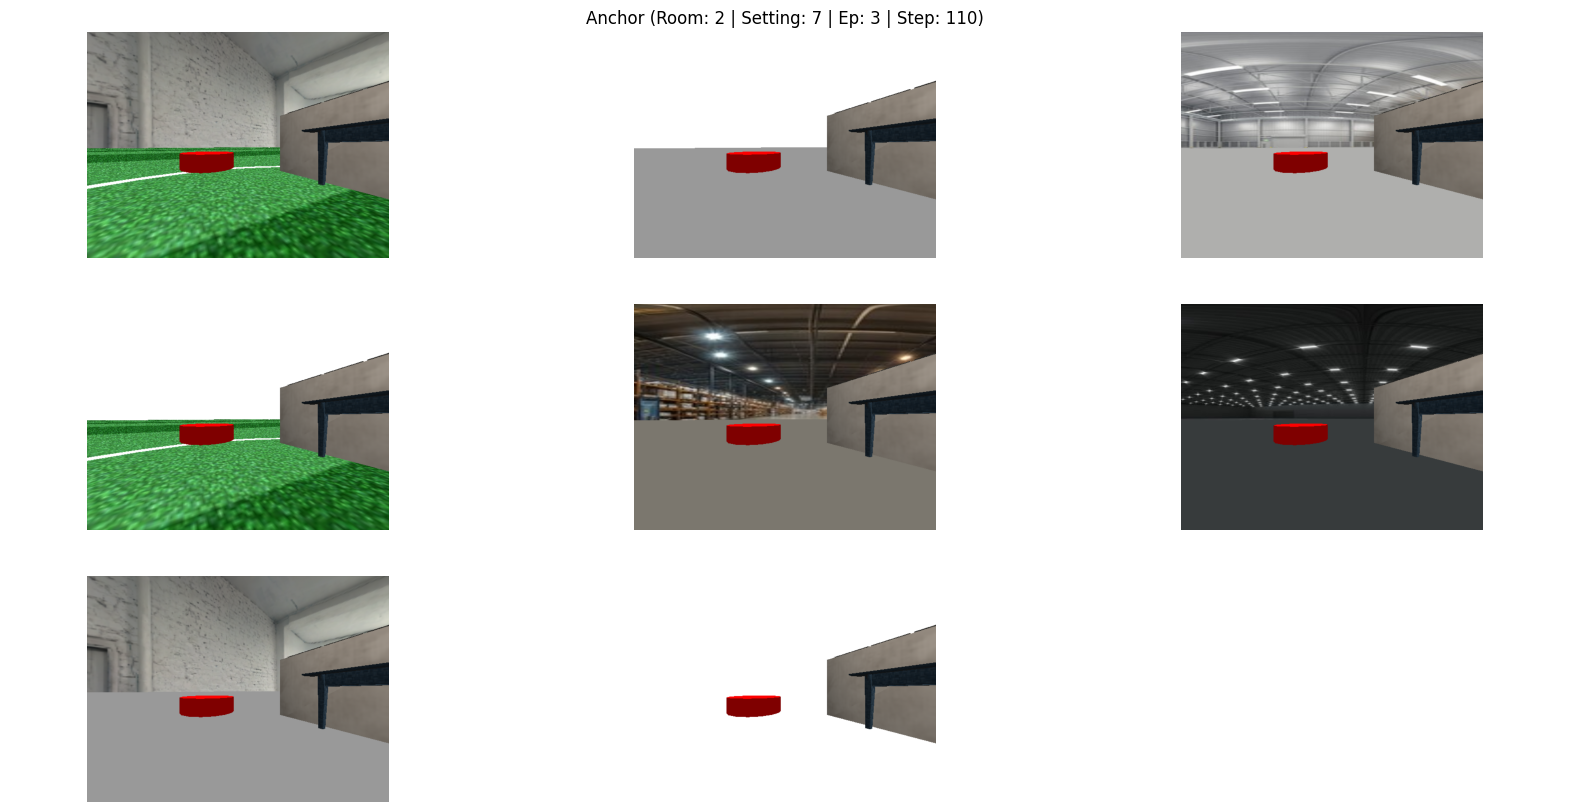

In [161]:
# Anchor image
anc_img = Image.open(f'./datasets/with-augmentations/Room{room}/Setting{setting}/episode_{ep:04}/rgb_{step:05}.png')
# Augmentations
aug_paths = glob(f'./datasets/with-augmentations/Room{room}/Setting{setting}/episode_{ep:04}/augmented_results/*_rgb_{step:05}.png')

# Plot
ROWS = 3
COLS = 3
plt.figure(figsize=[20,10])
plt.title(f'Anchor (Room: {room} | Setting: {setting} | Ep: {ep} | Step: {step})')
plt.axis('off')
plt.subplot(ROWS, COLS, 1)
plt.axis('off')
plt.imshow(anc_img)
for idx, path in enumerate(aug_paths):
    img = Image.open(path)
    plt.subplot(ROWS, COLS, idx+2)
    plt.axis('off')
    plt.imshow(img)

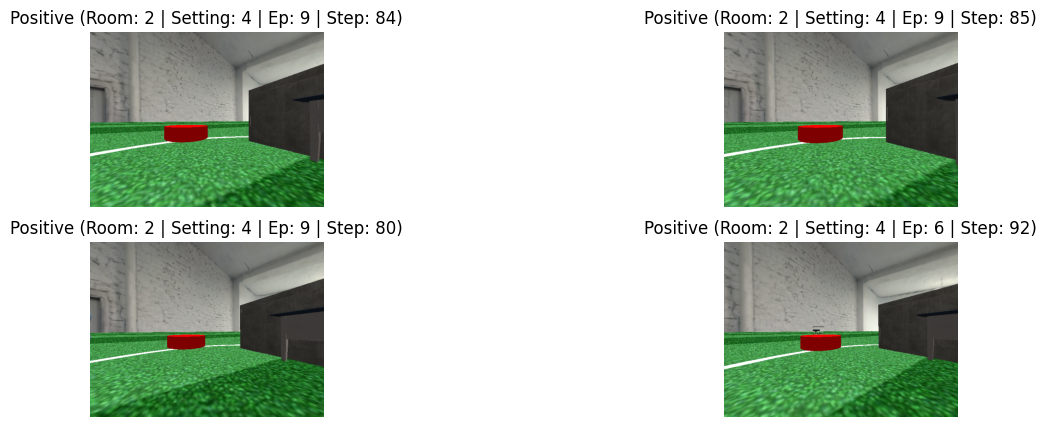

In [162]:
N_ROWS = 2
N_COLS = 2

# Plot positive examples by similarity
plt.figure(figsize=[15,5])
for idx, pos in enumerate(pos_imgs):
    img = Image.open(pos[0])
    plt.subplot(N_ROWS, N_COLS, idx+1)
    plt.title(f'Positive (Room: {pos[1]} | Setting: {pos[2]} | Ep: {pos[3]} | Step: {pos[4]})')
    plt.axis('off')
    plt.imshow(img)
plt.show();

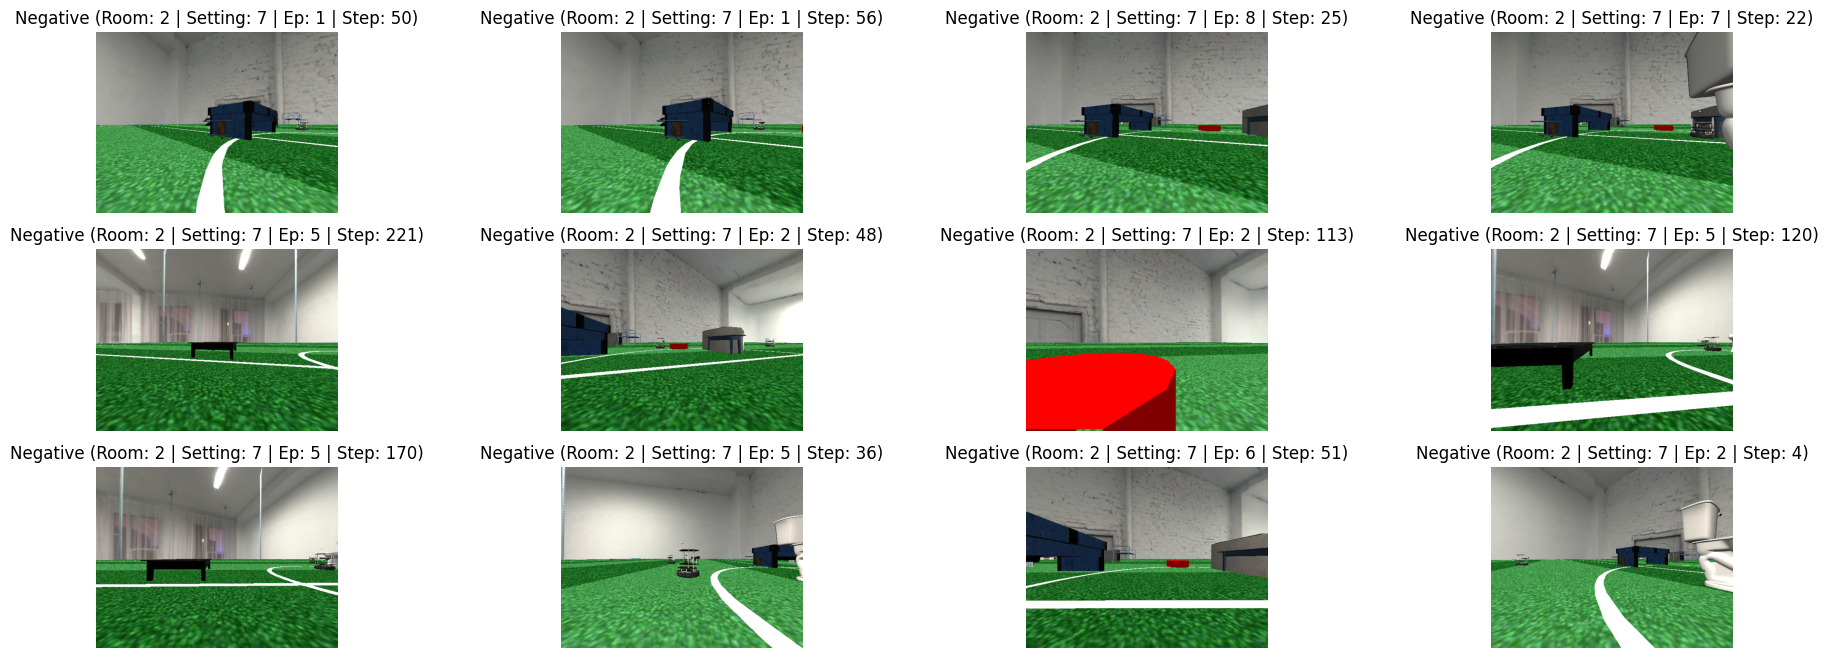

In [163]:
N_ROWS = 3
N_COLS = 4

# Plot negative examples by similarity
plt.figure(figsize=[23,8])
for idx, neg in enumerate(neg_imgs):
    img = Image.open(neg[0])
    plt.subplot(N_ROWS, N_COLS, idx+1)
    plt.title(f'Negative (Room: {neg[1]} | Setting: {neg[2]} | Ep: {neg[3]} | Step: {neg[4]})')
    plt.axis('off')
    plt.imshow(img)
plt.show();